# Logistic regression for SMS spam classification


Each line of the data file `sms.txt`
contains a label---either "spam" or "ham" (i.e. non-spam)---followed
by a text message. Here are a few examples (line breaks added for readability):

    ham     Ok lar... Joking wif u oni...
    ham     Nah I don't think he goes to usf, he lives around here though
    spam    Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.
            Text FA to 87121 to receive entry question(std txt rate)
            T&C's apply 08452810075over18's
    spam    WINNER!! As a valued network customer you have been
            selected to receivea £900 prize reward! To claim
            call 09061701461. Claim code KL341. Valid 12 hours only.

To create features suitable for logistic regression, code is provided to do the following (using tools from the ``sklearn.feature_extraction.text``):

* Convert words to lowercase.
* Remove punctuation and special characters (but convert the \$ and
  £ symbols to special tokens and keep them, because these are useful for predicting spam).
* Create a dictionary containing the 3000 words that appeared
  most frequently in the entire set of messages.
* Encode each message as a vector $\mathbf{x}^{(i)} \in
  \mathbb{R}^{3000}$. The entry $x^{(i)}_j$ is equal to the
  number of times the $j$th word in the dictionary appears in that
  message.
* Discard some ham messages to have an
  equal number of spam and ham messages.
* Split data into a training set of 1000 messages and a
  test set of 400 messages.
  
Follow the instructions below to complete the implementation. Your job will be to:

* Learn $\boldsymbol{\theta}$ by gradient descent
* Plot the cost history
* Make predictions and report the accuracy on the test set
* Test out the classifier on a few of your own text messages

# Load and prep data
This cell preps the data. Take a look to see how it works, and then run it.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import re
import matplotlib.pyplot as plt
import codecs

from logistic_regression import logistic, cost_function, gradient_descent
from sklearn.feature_extraction.text import CountVectorizer

# Preprocess the SMS Spam Collection data set
#  
#   https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
# 


numTrain    = 1000
numTest     = 494
numFeatures = 3000

np.random.seed(1)

# Open the file
f = codecs.open('sms.txt', encoding='utf-8')

labels = []    # list of labels for each message
docs   = []    # list of messages

# Go through each line of file and extract the label and the message
for line in f:
    l, d= line.strip().split('\t', 1)
    labels.append(l)
    docs.append(d)

# This function will be called on each message to preprocess it
def preprocess(doc):
    # Replace all currency signs and some url patterns by special
    # tokens. These are useful features.
    doc = re.sub('[£$]', ' __currency__ ', doc)
    doc = re.sub('\://', ' __url__ ', doc)
    doc = doc.lower() # convert to lower
    return doc


# This is the object that does the conversion from text to feature vectors
vectorizer = CountVectorizer(max_features=numFeatures, preprocessor=preprocess)

# Do the conversion ("fit" the transform from text to feature vector. 
#   later we will also "apply" the tranform on test messages)
X = vectorizer.fit_transform(docs)

# Convert labels to numbers: 1 = spam, 0 = ham
y = np.array([l == 'spam' for l in labels]).astype('int')

# The vectorizer returns sparse scipy arrays. Convert this back to a dense 
#   numpy array --- not as efficient but easier to work with
X = X.toarray()
m,n = X.shape

# Add a column of ones
X = np.column_stack([np.ones(m), X])

# 
# Now massage and split into test/train
# 
pos = np.nonzero(y == 1)[0]   # indices of positive training examples
neg = np.nonzero(y == 0)[0]   # indices of negative training examples

npos = len(pos)

# Create a subset that has the same number of positive and negative examples
subset = np.concatenate([pos, neg[0:len(pos)] ])

# Randomly shuffle order of examples
np.random.shuffle(subset)
      
X = X[subset,:]
y = y[subset]

# Split into test and train
train = np.arange(numTrain)
test  = numTrain + np.arange(numTest)

X_train = X[train,:]
y_train = y[train]

X_test  = X[test,:]
y_test  = y[test]

# Extract the list of test documents
test_docs = [docs[i] for i in subset[test]]

# Extract the list of tokens (words) in the dictionary
tokens = vectorizer.get_feature_names()

/Users/michaelgagliardi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Train logistic regresion model
Now train the logistic regression model. The comments summarize the relevant variables created by the preprocessing.

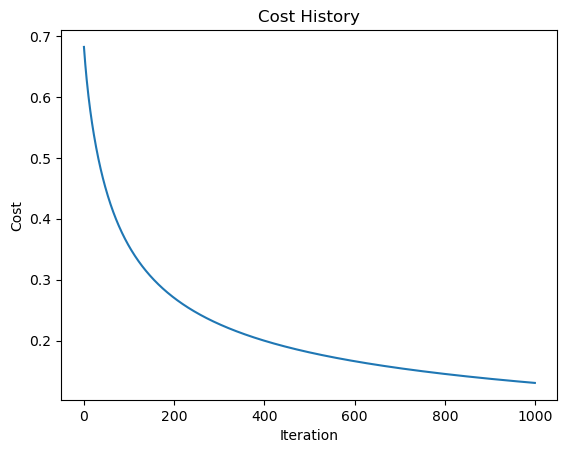

In [3]:
# X_train     contains information about the words within the training
#             messages. the ith row represents the ith training message. 
#             for a particular text, the entry in the jth column tells
#             you how many times the jth dictionary word appears in 
#             that message
#
# X_test      similar but for test set
#
# y_train     ith entry indicates whether message i is spam
#
# y_test      similar
#

m, n = X_train.shape

theta = np.zeros(n)


# YOUR CODE HERE: 
#  - learn theta by gradient descent 
#  - plot the cost history
#  - tune step size and # iterations if necessary

def logistic(z):
    """
    Logistic function which is the sigmoid function
    Input:
       z   numpy array (any shape)
    Output:
       p.  numpy array with same shape as z, where p = sigmoid(z) entrywise
    """
    p = 1 / (1 + np.exp(-z))
    return p

def logistic_cost(X, y, theta):
    """
    Compute the cost function for logistic regression.
    Inputs:
        X      data matrix (2d numpy array with shape m x n)
        y      label vector (1d numpy array -- length m)
        theta  parameter vector (1d numpy array -- length n)
    Output:
        cost   the value of the cost function (scalar)
    """
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    cost = (-1/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
    return cost

def logistic_regression(X, y, alpha, num_iters):
    """
    Fit a logistic regression model by gradient descent.
    Inputs:
        X          data matrix (2d numpy array with shape m x n)
        y          label vector (1d numpy array -- length m)
        alpha      step size (scalar)
        num_iters  number of iterations (integer)
    Return (tuple):
        theta      learned parameter vector (1d numpy array -- length n)
        J_history  cost function in iteration (1d numpy array -- length num_iters)
    """
    m, n = X.shape
    theta = np.zeros(n)
    J_history = []
    
    for i in range(num_iters):
        grad = (1/m) * np.dot(X.T, (logistic(np.dot(X, theta)) - y))
        theta = theta - alpha * grad
        J_history.append(logistic_cost(X, y, theta))
    
    return theta, J_history

# Training the logistic regression model
alpha=0.1
num_iters=1000

theta, J_history = logistic_regression(X_train, y_train, alpha, num_iters)

# Plotting the cost history
plt.plot(J_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost History')
plt.show()


# Make predictions on test set
Use the model fit in the previous cell to make predictions on the test set and compute the accuracy (percentage of messages in the test set that are classified correctly). You should be able to get accuracy above 95%.


In [24]:
m_test, n_test = X_test.shape

# Make predictions on test set
y_pred = np.round(logistic(np.dot(X_test, theta)))

# Compute accuracy
accuracy = np.mean(y_pred == y_test)
accuracy = "{:.2%}".format(accuracy)
print("Accuracy on test set: ",accuracy)


Accuracy on test set:  96.56%


# Inspect model parameters
Run this code to examine the model parameters you just learned. These parameters assign a postive or negative value to each word --- where positive values are words that tend to be spam and negative values are words that tend to be ham. Do they make sense?

In [5]:
token_weights = theta[1:]

def reverse(a):
    return a[::-1]

most_negative = np.argsort(token_weights)
most_positive = reverse(most_negative)

k = 10

print('Top %d spam words' % k)
for i in most_positive[0:k]:
    print('  %+.4f  %s' % (token_weights[i], tokens[i]))

print('\nTop %d ham words' % k)
for i in most_negative[0:k]:
    print('  %+.4f  %s' % (token_weights[i], tokens[i]))


Top 10 spam words
  +1.3921  call
  +1.3203  __currency__
  +0.9382  txt
  +0.8560  reply
  +0.8168  free
  +0.7639  from
  +0.7152  stop
  +0.7095  text
  +0.7003  your
  +0.6687  uk

Top 10 ham words
  -0.7945  my
  -0.6281  so
  -0.6043  me
  -0.4574  ok
  -0.4537  that
  -0.4213  ll
  -0.4006  gt
  -0.3935  but
  -0.3888  he
  -0.3846  lt


## Make a prediction on new messages
Type a few of your own messages in below and make predictions. Are they ham or spam? Do the predictions make sense?

In [15]:
def extract_features(msg):
    x = vectorizer.transform([msg]).toarray()
    x = np.insert(x, 0, 1)
    return x

# Define a few example text messages
texts = ["Hey Mom, give me a call when you can",
         "CONGRATULATIONS, visit the site below to win $1,000,000",
         "Hi Mike its Cara, you around for dinner next week?",
         "HURRY and click to claim your prize before it goes away!!!"]

# Loop over each text message and predict whether it's spam or not
for text in texts:
    # Extract features from text message
    x = extract_features(text)
    
    # Make prediction using logistic regression model
    y_pred = np.round(logistic(np.dot(x, theta)))
    
    # Print prediction
    if y_pred == 1:
        print("'%s' is predicted to be SPAM."%(text))
    else:
        print("'%s' is predicted to be HAM"%(text))

# YOUR CODE HERE
#  - try a few texts of your own
#  - predict whether they are spam or non-spam

'Hey Mom, give me a call when you can' is predicted to be HAM
'CONGRATULATIONS, visit the site below to win $1,000,000' is predicted to be SPAM.
'Hi Mike its Cara, you around for dinner next week?' is predicted to be HAM
'HURRY and click to claim your prize before it goes away!!!' is predicted to be SPAM.
